# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is a classification problem. We need to identify students that need intervention before fail to graduate. It means that our output must be something like "yes" or "no", 0 or 1, "need intervention" or "doesn't need intervention". These are a set of limited outputs, i.e., these are discrete ou categorical values for our output. If this were a regression problem, the output would be continuous values.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
from __future__ import division

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
student_data.columns

Index([u'school', u'sex', u'age', u'address', u'famsize', u'Pstatus', u'Medu',
       u'Fedu', u'Mjob', u'Fjob', u'reason', u'guardian', u'traveltime',
       u'studytime', u'failures', u'schoolsup', u'famsup', u'paid',
       u'activities', u'nursery', u'higher', u'internet', u'romantic',
       u'famrel', u'freetime', u'goout', u'Dalc', u'Walc', u'health',
       u'absences', u'passed'],
      dtype='object')

In [3]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns) -1

# TODO: Calculate passing students
n_passed = len(student_data[student_data.passed=="yes"])

# TODO: Calculate failing students
n_failed = len(student_data[student_data.passed=="no"])

# TODO: Calculate graduation rate
grad_rate =n_passed/n_students * 100
# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [4]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [5]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [6]:
X_all.head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,0,1,1,0,1,...,1,0,0,4,3,4,1,1,3,6
1,1,0,1,0,17,0,1,1,0,0,...,1,1,0,5,3,3,1,1,3,4
2,1,0,1,0,15,0,1,0,1,0,...,1,1,0,4,3,2,2,3,3,10
3,1,0,1,0,15,0,1,1,0,0,...,1,1,1,3,2,2,1,1,5,2
4,1,0,1,0,16,0,1,1,0,0,...,1,0,0,4,3,2,1,2,5,4


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [7]:
# TODO: Import any additional functionality you may need here
from sklearn.model_selection import train_test_split
# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
# X_train = None
# X_test = None
# y_train = None
# y_test = None
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=1973, stratify=y_all)
# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- **Gaussian Naive Bayes (GaussianNB)**
- Decision Trees
- **Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)**
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- **Logistic Regression**

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

#### Naive Bayes ####
- Naive Bayes has been used in cases such as face recognition, sentiment analysis, spam detection and text sorting. 
- **Strengths:**
    -  Easy and fast to implement
    -  Easy to understand
    -  Can be used for online learning
- **Weaknesses:**
    -  Fails estimating rare occurrences
    -  Suffers from irrelevant features
    -  Strong feature indepence assumptions
- **Applicability: **
    - Naive Bayes is very simple and very cheap in terms of computation and, since it is good with small datasets for training I thing it is a good candidate to solve our problem.
    - _ref: Building Machine Learning with Python, Willi Richert and Luis Pedro Coelho - Packt Publishing. Page 146_
    

#### Ensemble Methods - Random Forest ####
- Applications include classification of internet traffic, bioinformatics like , gene expression classification, mass spectrum protein expression analysis, biomarker discovery, sequence annotation, protein-protein interaction prediction. 
- **Strengths:**
    - Classification tree ensembles perform very well in practice. They are robust to outliers, scalable, and able to naturally model non-linear decision boundaries thanks to their hierarchical structure.
- **Weaknesses:**
    -  Difficult to interpret
    -  Weaker on regression whe estimating values at the extremities of the distribution of response values
    -  Biased in multiclass problems toward more frequent classes
- **Applicability: **
    - Decision trees are very good in classification problems, and using Random Forest we have more consistent results. Since random forest will create a bunch of random decision trees, it can deal with these results to pick the best. Another point is that in our case, we didn't even create the dummy variables because random forest is able to work with discrete and categorical variables. Besides that, random forest is not prone to overfit the model like a single decision tree.

#### Logistic Regression ####
- Applications include ordering results by probability, modelling marketing responses.
- **Strengths**:
    - Outputs have a nice probabilistic interpretation, and the algorithm can be regularized to avoid overfitting. Logistic models can be updated easily with new data using stochastic gradient descent.
- **Weaknesses:**
    - Logistic regression tends to underperform when there are multiple or non-linear decision boundaries. They are not flexible enough to naturally capture more complex relationships.
- **Applicability: **
    - We have a binary classification with most part our features as continuous and/or categorical data. 


_Refs:_

[Machine Learning for Dummies Cheat Sheet](http://www.dummies.com/programming/big-data/data-science/machine-learning-dummies-cheat-sheet/)

[Modern Machine Learning Algorithms: Strengths and Weaknesses](https://elitedatascience.com/machine-learning-algorithms)



### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [8]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=1973)
clf_C = RandomForestClassifier(random_state=1973)

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train
y_train_300 = y_train

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for clf in [clf_A, clf_B, clf_C]:
    for size in [100, 200, 300]:
        train_predict(clf, X_train[:size], y_train[:size], X_test, y_test)
    print '='*80 # imprime linha

    

Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0150 seconds
Made predictions in 0.0040 seconds.
F1 score for training set: 0.3218.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.2078.
Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0040 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.7925.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.7727.
Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0000 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.7961.
Made predictions in 0.0160 seconds.
F1 score for test set: 0.7852.
Training a LogisticRegression using a training set size of 100. . .
Trained model in 0.0210 seconds
Made predictions in 0.0160 seconds.
F1 score for training set: 0.9114.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7500.
Training a LogisticRegression using a training set size of 200. . .
Trai

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - GaussianNB**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0060 seconds      |     0.0020 seconds     |      0.3218      |      0.2078     |
| 200               |     0.0060 seconds      |     0.0030 seconds     |      0.7925      |      0.7727     |
| 300               |     0.0060 seconds      |     0.0030 seconds     |      0.0761      |      0.7852     |

** Classifer 2 - Logistic Regression **

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0090 seconds      |     0.0000 seconds     |      0.9114      |      0.7500     |
| 200               |     0.0190 seconds      |     0.0000 seconds     |      0.8293      |      0.7606     |
| 300               |     0.0320 seconds      |     0.0000 seconds     |      0.8435      |      0.8138     |

** Classifer 3 - Random Forest **

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.1890 seconds      |     0.0010 seconds     |      1.0000      |      0.7671     |
| 200               |     0.1300 seconds      |     0.0160 seconds     |      0.9924      |      0.6970     |
| 300               |     0.1730 seconds      |     0.0000 seconds     |      0.9875      |      0.7445     |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** I've decide to use Random Forest despite GaussianNB got better results. In my researches, GaussianNB doesn't have ways to improve the results with GridSearchCV. The Random Forest has a bigger training time, but it seems very fast in prediction time with high train and test F1 scores. Beyond that, RandomForestClassifier has many hyperparameters to tuning the algorithm.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** Random Forest is just a bunch of decision trees. Decision tree is an algorithm that make simple questions in order to categorize the data. For example, if a bank needs to decide whether to lend money to a customer, it will check its historical data and start to make a serie of questions. Based on answers the bank can conclude if it will lend money or not.
However trust in a single decision tree could be a weak decision. Then we used Random Forest, that I said before, it is a bunch of decision trees. The algorithm combine many trees to get a better result. The bunch of decision trees are generated randomly. In our case we have a dataset with 30 features. Not all features are used in each of decision trees. Let's suppose that you use 20% of features of each decision tree. That means the algorithm will select randomly 6 features for each tree. This technique guarantees to train the data in numerous different decision trees. With the results of this series of decision trees, the algorithm can decide the best classification for specific input. The decision is made by vote. For example: we run the algorithm with 100 decision trees. A specific student was classified as "passed" in 85 decision trees and "not passed" in 15 trees. In this case, the majority vote for this student is "passed" and that is the result of the algorithm.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [10]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {"n_estimators":[10, 50, 100],
              "criterion":["gini", "entropy"]}

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=1973)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
# [REVIEW]
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

print(grid_obj.best_params_)

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(grid_obj, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(grid_obj, X_test, y_test))
print ("--------------------------------------------------------------------------")



{'n_estimators': 50, 'criterion': 'entropy'}
Made predictions in 0.0150 seconds.
Tuned model has a training F1 score of 1.0000.
Made predictions in 0.0160 seconds.
Tuned model has a testing F1 score of 0.8322.
--------------------------------------------------------------------------


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

- Tuned model has a training F1 score of 1.0000.
- Tuned model has a testing F1 score of 0.8322.

The tuned Random Forest model had a good increase in performance comparing the F1 score. The original F1 test score for 300 points was 0.7445 and now it is 0.8322. The original F1 train score for 300 points was 0.9875 and now it is 1.0

The final parameters that GridSearchCV foud are:
- n_estimators: 50
- criterion: entropy


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

Text(0.5,24,u'Predicted')

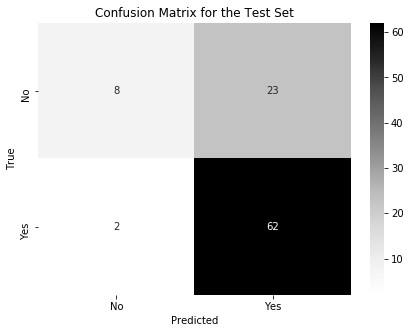

In [12]:
import seaborn as sns # Install using 'pip install seaborn'
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

cm_test = confusion_matrix(y_test, grid_obj.predict(X_test))

plt.figure(figsize=(7,5))
sns.heatmap(cm_test, annot=True, cmap='Greys', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix for the Test Set')
plt.ylabel('True')
plt.xlabel('Predicted')